In [1]:
import torch
from torch import nn
import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.utils import make_grid

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchstat import stat

from tqdm import tqdm, trange
import wandb
from torchvision.utils import save_image
import numpy as np
import matplotlib
torch.manual_seed(2022)

# matplotlib.style.use('ggplot')

## 定义生成器和辨别器

In [2]:
# generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),  # B, 512, 4, 4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 256, 8, 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 128, 16, 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 64, 32, 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 3, 64, 64
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [3]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 64, 32, 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 128, 16, 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 256, 8, 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),  # B, 512, 4, 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),  # B, 1, 1, 1
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

## utils

In [4]:
# set the computation device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)
    
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. 
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 定义超参数

In [5]:
# learning parameters / configurations according to paper
image_size = 64 # resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train
# set the computation device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## 加载数据集

In [6]:
# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])
# prepare the data
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## 初始化生成器、辨别器

In [7]:
# initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 
# initialize generator weights
generator.apply(weights_init)
# initialize discriminator weights
discriminator.apply(weights_init)
pass

## 定义优化器和损失函数

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
# loss function
criterion = nn.BCELoss()
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

## 定义辨别器训练函数

In [9]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1, 1)
    loss_real = criterion(output_real, real_label)
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake).view(-1, 1)
    loss_fake = criterion(output_fake, fake_label)
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

## 定义生成器训练函数

In [10]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake).view(-1, 1)
    loss = criterion(output, real_label)
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

## 训练

In [11]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [12]:
generator.train()
discriminator.train()
pass

In [ ]:
wandb.init(project="Gan", name="DCGAN", entity="ruizhuo_xu")

391it [01:12,  5.40it/s]                         


Epoch 1 of 25
Generator loss: 7.07964277, Discriminator loss: 0.53897995


391it [01:11,  5.43it/s]                         


Epoch 2 of 25
Generator loss: 4.82479954, Discriminator loss: 0.57265359


391it [01:11,  5.46it/s]                         


Epoch 3 of 25
Generator loss: 4.02619410, Discriminator loss: 0.60660928


391it [01:11,  5.47it/s]                         


Epoch 4 of 25
Generator loss: 3.72084498, Discriminator loss: 0.66461670


391it [01:11,  5.48it/s]                         


Epoch 5 of 25
Generator loss: 3.15810084, Discriminator loss: 0.73089093


391it [01:11,  5.48it/s]                         


Epoch 6 of 25
Generator loss: 2.68420458, Discriminator loss: 0.74902320


391it [01:11,  5.48it/s]                         


Epoch 7 of 25
Generator loss: 2.73425364, Discriminator loss: 0.80198789


391it [01:11,  5.48it/s]                         


Epoch 8 of 25
Generator loss: 2.84089231, Discriminator loss: 0.70242101


391it [01:11,  5.48it/s]                         


Epoch 9 of 25
Generator loss: 2.97920871, Discriminator loss: 0.70320791


391it [01:11,  5.48it/s]                         


Epoch 10 of 25
Generator loss: 3.07601976, Discriminator loss: 0.72476786


391it [01:11,  5.48it/s]                         


Epoch 11 of 25
Generator loss: 2.99274135, Discriminator loss: 0.70000315


391it [01:11,  5.48it/s]                         


Epoch 12 of 25
Generator loss: 3.22024751, Discriminator loss: 0.62051994


391it [01:11,  5.48it/s]                         


Epoch 13 of 25
Generator loss: 3.24961066, Discriminator loss: 0.64505267


391it [01:11,  5.48it/s]                         


Epoch 14 of 25
Generator loss: 3.30146241, Discriminator loss: 0.62684941


391it [01:11,  5.48it/s]                         


Epoch 15 of 25
Generator loss: 3.20045519, Discriminator loss: 0.63198149


391it [01:11,  5.48it/s]                         


Epoch 16 of 25
Generator loss: 3.02085304, Discriminator loss: 0.68590868


391it [01:11,  5.48it/s]                         


Epoch 17 of 25
Generator loss: 2.58412337, Discriminator loss: 0.74667317


391it [01:11,  5.48it/s]                         


Epoch 18 of 25
Generator loss: 3.73293161, Discriminator loss: 0.53726751


391it [01:11,  5.48it/s]                         


Epoch 19 of 25
Generator loss: 3.33780932, Discriminator loss: 0.61973238


391it [01:11,  5.48it/s]                         


Epoch 20 of 25
Generator loss: 2.87590408, Discriminator loss: 0.74018019


391it [01:11,  5.48it/s]                         


Epoch 21 of 25
Generator loss: 3.07948160, Discriminator loss: 0.65658629


391it [01:11,  5.48it/s]                         


Epoch 22 of 25
Generator loss: 4.61816216, Discriminator loss: 0.29983252


391it [01:11,  5.48it/s]                         


Epoch 23 of 25
Generator loss: 2.95470262, Discriminator loss: 0.72545409


391it [01:11,  5.48it/s]                         


Epoch 24 of 25
Generator loss: 3.68353558, Discriminator loss: 0.51439011


391it [01:11,  5.48it/s]                         


Epoch 25 of 25
Generator loss: 2.36771941, Discriminator loss: 0.82173616
DONE TRAINING


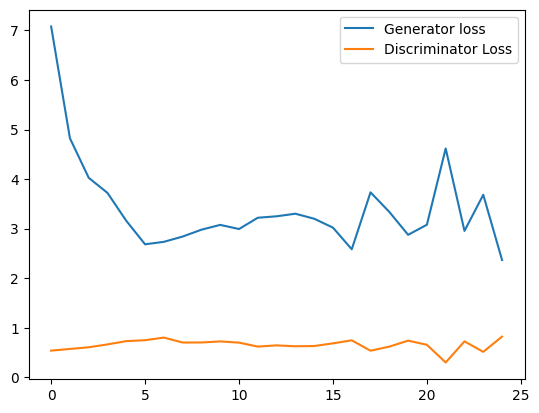

In [13]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./outputs_25_/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    # wandb.log(
    #     {
    #         "D_loss_epoch": epoch_loss_d,
    #         "G_loss_epoch": epoch_loss_g,
    #         "generated_img": wandb.Image(make_grid(generated_img, nrow=8, normalize=True)),
    #         "epoch": epoch+1

    #     }
    # )
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    torch.save(generator.state_dict(), f'./outputs_25_/generator_{epoch}.pth')
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), './outputs_25/generator.pth')
# plot and save the generator and discriminator loss
plt.figure()
losses_d = [x.item() for x in losses_d]
losses_g = [x.item() for x in losses_g]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs_25_/loss.png')
plt.show()

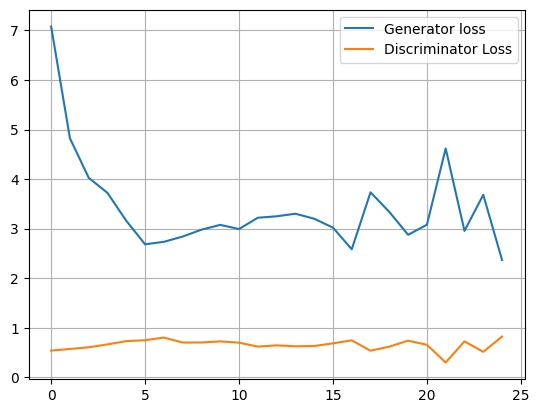

In [15]:
# plot and save the generator and discriminator loss
plt.figure()
losses_d = [x for x in losses_d]
losses_g = [x for x in losses_g]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.grid()
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()

In [19]:
check_point = torch.load('./outputs_25/generator.pth')
generator = Generator(nz=nz)
generator.load_state_dict(check_point)
generator.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

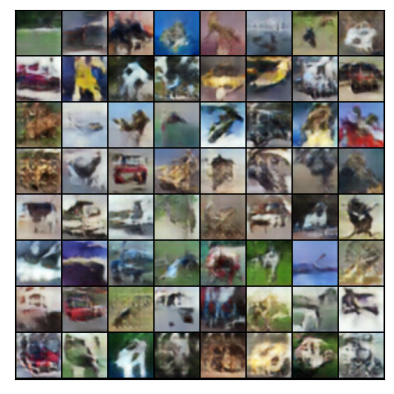

In [21]:
noise = create_noise(64, nz)
img_gen = generator(noise)
img_gen = make_grid(img_gen, nrow=8, normalize=True).cpu().detach()
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(transforms.ToPILImage()(img_gen))

In [33]:
img_gen.shape

torch.Size([3, 530, 530])